In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import os

# Import Data

In [2]:
train_identity_df = pd.read_csv("./train_identity.csv")
train_transaction_df = pd.read_csv("./train_transaction.csv")

test_identity_df = pd.read_csv("./test_identity.csv")
test_transaction_df = pd.read_csv("./test_transaction.csv")

In [3]:
train = train_transaction_df.merge(train_identity_df, on='TransactionID', how='left')
test = test_transaction_df.merge(test_identity_df, on='TransactionID', how='left')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (590540, 434)
Test shape: (506691, 433)


In [4]:
# Save IDs and target
test_ids = test["TransactionID"].copy()
TARGET = "isFraud"

y = train[TARGET].copy()

In [5]:
train["isTrain"] = 1
test["isTrain"] = 0

full_datasets = pd.concat([train, test], axis=0, ignore_index=True)

# Tools

In [6]:
class UniqueValueAnalyzer:
    def __init__(self, df):
        """
        Initialize the analyzer with a pandas DataFrame.
        """
        self.df = df

    def analyze(self, dtype_include=['object']):
        """
        Analyze columns of specific dtype (default: object) to get:
        - Number of unique values (including NaN)
        - Non-missing values count
        - Missing values count
        - Total values
        - Value counts dictionary
        """
        unique_values_info = []

        # Loop through columns with specified dtype
        for col in self.df.select_dtypes(include=dtype_include).columns:
            total_values = len(self.df[col])
            non_missing_count = self.df[col].notnull().sum()
            missing_count = self.df[col].isnull().sum()
            unique_count = self.df[col].nunique(dropna=False)  # count NaN as unique
            value_counts = self.df[col].value_counts(dropna=False).to_dict()  # include NaN in counts

            unique_values_info.append({
                'Column': col,
                'Number of Unique Values': unique_count,
                'Non Missing Values': non_missing_count,
                'Missing Values': missing_count,
                'Total Values': total_values,
                'Value Counts': value_counts
            })

        # Return results as DataFrame
        return pd.DataFrame(unique_values_info)


# ===== Example Usage =====
# analyzer = UniqueValueAnalyzer(train_identity_df)
# result_df = analyzer.analyze(dtype_include=['object'])  # or ['int64', 'float64']
# print(result_df.head())


In [7]:

def plot_missing_values(df, title="Missing Values per Column"):
    """
    Plot the missing values per column for any DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    title (str): Title for the plot.
    """
    # Calculate missing values per column
    missing_values = df.isnull().sum()

    # Keep only columns with missing values
    missing_values = missing_values[missing_values > 0]

    # If no missing values, print message and exit
    if missing_values.empty:
        print("No missing values found.")
        return

    # Sort by the number of missing values (descending)
    missing_values = missing_values.sort_values(ascending=False)

    # Create a DataFrame for visualization
    missing_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Values': missing_values.values,
        'Percentage': (missing_values.values / len(df)) * 100
    })
    
    # Display the table
    print(missing_df)

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Missing Values',
        y='Column',
        hue='Column', 
        data=missing_df,
        palette='viridis',
        legend=False
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Number of Missing Values")
    plt.ylabel("Column Name")
    plt.tight_layout()
    plt.show()


# ===== Example Usage =====
# plot_missing_values(train_identity_df, title="Missing Values in train_identity_df")
# plot_missing_values(train_transaction_df, title="Missing Values in train_transaction_df")

In [8]:
def missing_values_percentage(df):
    missing_values_count = df.isnull().sum()
    total_rows = len(df)
    missing_values_percentage = (missing_values_count / total_rows) * 100

    return missing_values_percentage

In [9]:
def group_by_with_label(df, col, label_col):
    grouped_df = df.groupby(col)[label_col].value_counts().unstack(fill_value=0)
    grouped_df.columns = [f'{label_col}_0', f'{label_col}_1']
    grouped_df['total'] = (grouped_df[f'{label_col}_1'] + grouped_df[f'{label_col}_0'])
    grouped_df[f"{label_col}_rate"] = grouped_df[f'{label_col}_1'] / grouped_df['total']
    grouped_df.reset_index(inplace=True)
    return grouped_df

In [10]:
def plot_label_rate_by_bin(df: pd.DataFrame, column_to_bin: str, target_col: str, num_bins=10):
    df_copy = df[[column_to_bin, target_col]].copy()

    df_copy[f'{column_to_bin}_bin'] = pd.qcut(
        df_copy[column_to_bin],
        q=num_bins,
        duplicates='drop'
    )

    fraud_rate_by_bin = df_copy.groupby(f'{column_to_bin}_bin')[target_col].mean()

    # Plot the results
    fig, ax = plt.subplots(figsize=(8, 4))
    fraud_rate_by_bin.plot(kind='line', marker='o', ax=ax)
    ax.set_title(f"Rate by {column_to_bin} (Binned)", fontsize=16)
    ax.set_xlabel(f"{column_to_bin} Bin", fontsize=12)
    ax.set_ylabel("Label Rate", fontsize=12)
    ax.set_xticks(range(len(fraud_rate_by_bin)))
    ax.set_xticklabels([str(interval) for interval in fraud_rate_by_bin.index], rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [11]:
def calculate_iv(data: pd.DataFrame, feature: str, target: str):
    crosstab = pd.crosstab(data[feature], data[target], normalize=False)
    crosstab.columns = ['Good', 'Bad']
    crosstab['Total'] = crosstab['Good'] + crosstab['Bad']
    crosstab['Good%'] = crosstab['Good'] / crosstab['Good'].sum()
    crosstab['Bad%'] = crosstab['Bad'] / crosstab['Bad'].sum()
    crosstab = crosstab[(crosstab['Good%'] > 0) & (crosstab['Bad%'] > 0)]
    crosstab['WOE'] = np.log(crosstab['Good%'] / crosstab['Bad%'])
    crosstab['IV'] = (crosstab['Good%'] - crosstab['Bad%']) * crosstab['WOE']
    return crosstab['IV'].sum()

# Exploratory Data Analysis (EDA)

## Train Identity DF

The train_identity.csv file holds supplementary, anonymized identity and device metadata that can be joined with transaction data to improve fraud detection models. The id_01–id_38 columns are cryptic by design (to protect privacy) but serve as important engineered features for detecting abnormal or suspicious patterns.

### Data Overview

In [12]:
train_identity_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


### Data Type Overview

In [13]:
# --- Data Type Overview ---
print("\nData types BEFORE preprocessing:")
print(train_identity_df.dtypes.value_counts())


Data types BEFORE preprocessing:
float64    23
object     17
int64       1
Name: count, dtype: int64


### Data Shape Overview & Check Duplicates

In [14]:
# Count total rows
train_identity_shape = train_identity_df.shape

# Count unique TransactionID values
unique_count = train_identity_df["TransactionID"].nunique()

# Print results
print(f"Total rows (shape[0])               : {train_identity_shape[0]}")
print(f"Total columns (shape[1])            : {train_identity_shape[1]}")
print(f"Number of unique TransactionID      : {unique_count}")

# Check if total rows equals number of unique TransactionID
if train_identity_shape[0] == unique_count:
    print("✅ No duplicate TransactionID found in train_identity_df.")
else:
    print("⚠️ Duplicate TransactionID detected in train_identity_df.")


Total rows (shape[0])               : 144233
Total columns (shape[1])            : 41
Number of unique TransactionID      : 144233
✅ No duplicate TransactionID found in train_identity_df.


### List All Column Names

In [15]:
# List all column names
train_identity_df.columns.tolist()

['TransactionID',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

### Missing Values Overview

        Column  Missing Values  Percentage
0        id_24          139486   96.708798
1        id_25          139101   96.441868
2        id_07          139078   96.425922
3        id_08          139078   96.425922
4        id_21          139074   96.423149
5        id_26          139070   96.420375
6        id_27          139064   96.416215
7        id_23          139064   96.416215
8        id_22          139064   96.416215
9        id_18           99120   68.722137
10       id_03           77909   54.016071
11       id_04           77909   54.016071
12       id_33           70944   49.187079
13       id_10           69307   48.052110
14       id_09           69307   48.052110
15       id_30           66668   46.222432
16       id_32           66647   46.207872
17       id_34           66428   46.056034
18       id_14           64189   44.503685
19  DeviceInfo           25567   17.726179
20       id_13           16913   11.726165
21       id_16           14893   10.325654
22       id

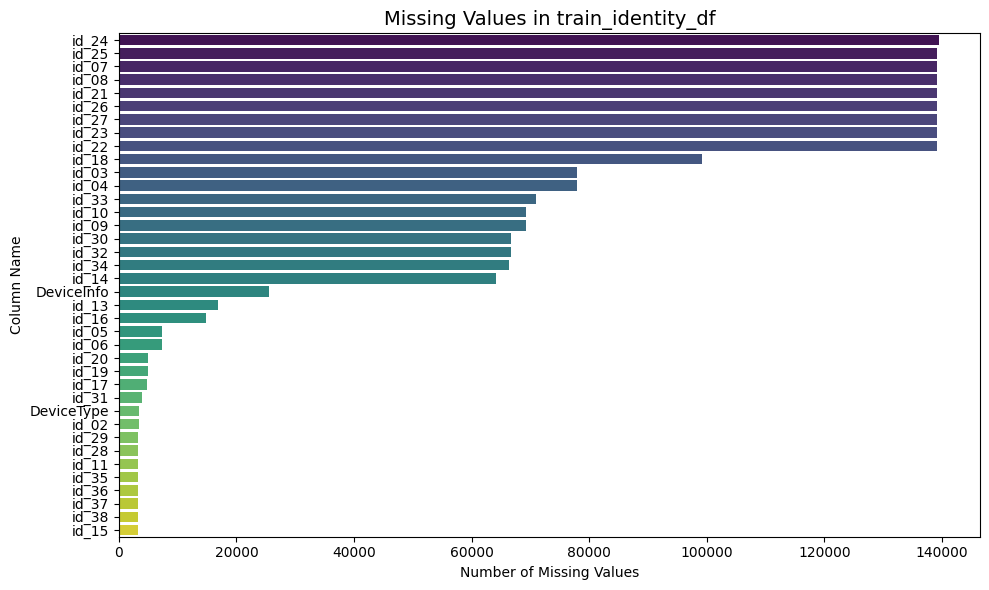

In [16]:
plot_missing_values(train_identity_df, title="Missing Values in train_identity_df")

### Described Train Identity

In [17]:
train_identity_df.describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577534e+06,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


### Train Identity Dataset Unique Values Overview

In [18]:
train_identitiy_analyzer = UniqueValueAnalyzer(train_identity_df)
train_identitiy_analyzer_result_df = train_identitiy_analyzer.analyze(dtype_include=['object'])
train_identitiy_analyzer_result_df.head()

,Column,Number of Unique Values,Non Missing Values,Missing Values,Total Values,Value Counts
0,id_12,2,144233,0,144233,"{'NotFound': 123025, 'Found': 21208}"
1,id_15,4,140985,3248,144233,"{'Found': 67728, 'New': 61612, 'Unknown': 1164..."
2,id_16,3,129340,14893,144233,"{'Found': 66324, 'NotFound': 63016, nan: 14893}"
3,id_23,4,5169,139064,144233,"{nan: 139064, 'IP_PROXY:TRANSPARENT': 3489, 'I..."
4,id_27,3,5169,139064,144233,"{nan: 139064, 'Found': 5155, 'NotFound': 14}"


## Train Transaction DF

The train_transaction.csv file serves as the core dataset with both:

- Predictive features: details of the transaction, payment method, user behavior patterns, etc.

- Target variable: isFraud indicating if the transaction was fraudulent.

When combined with train_identity.csv (via TransactionID), it gives a fuller picture of each transaction, including device and identity details.

### Data Overview

In [19]:
train_transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Type Overview

In [20]:
# --- Data Type Overview ---
print("\nData types BEFORE preprocessing:")
print(train_transaction_df.dtypes.value_counts())


Data types BEFORE preprocessing:
float64    376
object      14
int64        4
Name: count, dtype: int64


### Data Shape Overview & Check Duplicates

In [21]:
# Count total rows
train_transaction_df_shape = train_transaction_df.shape

# Count unique TransactionID values
unique_count = train_transaction_df["TransactionID"].nunique()

# Print results
print(f"Total rows (shape[0])               : {train_transaction_df_shape[0]}")
print(f"Total columns (shape[1])            : {train_transaction_df_shape[1]}")
print(f"Number of unique TransactionID      : {unique_count}")

# Check if total rows equals number of unique TransactionID
if train_transaction_df_shape[0] == unique_count:
    print("✅ No duplicate TransactionID found in train_transaction_df.")
else:
    print("⚠️ Duplicate TransactionID detected in train_transaction_df.")


Total rows (shape[0])               : 590540
Total columns (shape[1])            : 394
Number of unique TransactionID      : 590540
✅ No duplicate TransactionID found in train_transaction_df.


### List All Column Names

In [22]:
# List all column names
train_transaction_df.columns.tolist()

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

### Calculate Fraud Ratio In Train Transaction Dataset

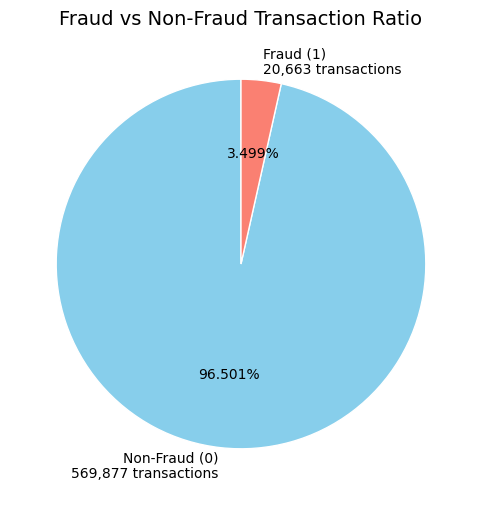

In [23]:
# Calculate the sum of each isFraud value
fraud_counts = train_transaction_df["isFraud"].value_counts()

# Create labels with specific quantities
labels = [f"Non-Fraud (0)\n{fraud_counts[0]:,} transactions",
          f"Fraud (1)\n{fraud_counts[1]:,} transactions"]

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    fraud_counts,
    labels=labels,
    autopct="%1.3f%%",
    colors=["skyblue", "salmon"],
    startangle=90,
    wedgeprops={"edgecolor": "white"}
)

plt.title("Fraud vs Non-Fraud Transaction Ratio", fontsize=14)
plt.show()


### Missing Values Overview

    Column  Missing Values  Percentage
0    dist2          552913   93.628374
1       D7          551623   93.409930
2      D13          528588   89.509263
3      D14          528353   89.469469
4      D12          525823   89.041047
..     ...             ...         ...
369   V307              12    0.002032
370   V308              12    0.002032
371   V309              12    0.002032
372   V279              12    0.002032
373   V294              12    0.002032

[374 rows x 3 columns]


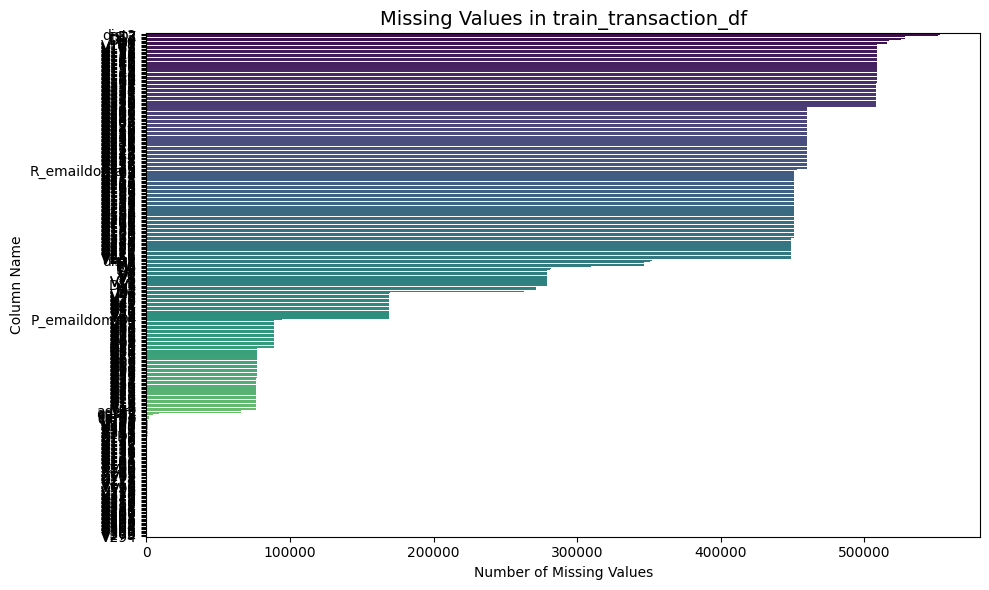

In [24]:
plot_missing_values(train_transaction_df, title="Missing Values in train_transaction_df")

### Described Train Transaction

In [25]:
train_transaction_df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


### Train Transaction Dataset Unique Values Overview

In [26]:
train_transaction_analyzer = UniqueValueAnalyzer(train_transaction_df)
train_transaction_analyzer_result_df = train_transaction_analyzer.analyze(dtype_include=['object'])
train_transaction_analyzer_result_df.head()

,Column,Number of Unique Values,Non Missing Values,Missing Values,Total Values,Value Counts
0,ProductCD,5,590540,0,590540,"{'W': 439670, 'C': 68519, 'R': 37699, 'H': 330..."
1,card4,5,588963,1577,590540,"{'visa': 384767, 'mastercard': 189217, 'americ..."
2,card6,5,588969,1571,590540,"{'debit': 439938, 'credit': 148986, nan: 1571,..."
3,P_emaildomain,60,496084,94456,590540,"{'gmail.com': 228355, 'yahoo.com': 100934, nan..."
4,R_emaildomain,61,137291,453249,590540,"{nan: 453249, 'gmail.com': 57147, 'hotmail.com..."


### Unique Person

Why Create a Unique Person ID?
1. card1–card6 contain specific card attributes

    These columns store partially masked or encoded card details, such as:
    - card1: Unique or partial card ID
    - card2: Issuer bank code
    - card3: Issuing region
    - card4: Card type (Visa, Mastercard, etc.)
    - card5: Expiration year
    - card6: Account type (debit, credit, prepaid)

    A single card typically belongs to one person or account.

2. addr1 and addr2 indicate location

    - addr1: Area/region/state code
    - addr2: Country or broader region

    These help distinguish transactions from the same card used in different locations.

3. Adding P_emaildomain and R_emaildomain for more precision

    - P_emaildomain: Purchaser’s email domain
    - R_emaildomain: Recipient’s email domain

    Including email domains further increases the uniqueness of the person identifier.

4. Why combine them?
    
    Using just one feature (e.g., card1) might overlap between different people.
    Combining card1–card6 + addr1–addr2 + P_emaildomain + R_emaildomain drastically reduces the chance of collisions, making the ID more reliable.

5. Benefits for fraud analysis

    - Track the number of transactions per person
    - Analyze purchase patterns
    - Detect repeated fraud attempts by the same individual

In [27]:
# Create a unique identifier by combining card1-card6, addr1-addr2, P_emaildomain, and R_emaildomain
train_transaction_df["unique_id"] = (
    train_transaction_df["card1"].astype(str) + "_" +
    train_transaction_df["card2"].astype(str) + "_" +
    train_transaction_df["card3"].astype(str) + "_" +
    train_transaction_df["card4"].astype(str) + "_" +
    train_transaction_df["card5"].astype(str) + "_" +
    train_transaction_df["card6"].astype(str) + "_" +
    train_transaction_df["addr1"].astype(str) + "_" +
    train_transaction_df["addr2"].astype(str) + "_" +
    train_transaction_df["P_emaildomain"].astype(str) + "_" +
    train_transaction_df["R_emaildomain"].astype(str)
)

# Count the total rows
total_rows = train_transaction_df.shape[0]

# Count the number of unique TransactionIDs
unique_transaction_ids = train_transaction_df["TransactionID"].nunique()

# Count the number of unique person IDs
unique_person_ids = train_transaction_df["unique_id"].nunique()

# Print results
print(f"Total rows                        : {total_rows}")
print(f"Unique TransactionIDs              : {unique_transaction_ids}")
print(f"Unique person IDs (card+addr+email combo): {unique_person_ids}")

# Check if each TransactionID comes from a different person
if unique_transaction_ids == unique_person_ids:
    print("✅ Each TransactionID belongs to a different unique person.")
else:
    print("⚠️ Multiple transactions may come from the same person.")


Total rows                        : 590540
Unique TransactionIDs              : 590540
Unique person IDs (card+addr+email combo): 114187
⚠️ Multiple transactions may come from the same person.


In [28]:
test_transaction_df[
        [col for col in test_transaction_df.columns if 'card' in col] + 
        ['addr1', 'addr2'] + 
        ['P_emaildomain', 'R_emaildomain']
    ]

,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain
0,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,gmail.com,NaN
1,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,aol.com,NaN
2,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,hotmail.com,NaN
3,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,gmail.com,NaN
4,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,gmail.com,NaN
...,...,...,...,...,...,...,...,...,...,...
506686,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,gmail.com,gmail.com
506687,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,hotmail.com,hotmail.com
506688,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,hotmail.com,NaN
506689,16621,516.0,150.0,mastercard,224.0,debit,177.0,87.0,hotmail.com,NaN


In [29]:
train_transaction_df[
        [col for col in train_transaction_df.columns if 'card' in col] + 
        ['addr1', 'addr2'] + 
        ['P_emaildomain', 'R_emaildomain']
    ].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   card1          590540 non-null  int64  
 1   card2          581607 non-null  float64
 2   card3          588975 non-null  float64
 3   card4          588963 non-null  object 
 4   card5          586281 non-null  float64
 5   card6          588969 non-null  object 
 6   addr1          524834 non-null  float64
 7   addr2          524834 non-null  float64
 8   P_emaildomain  496084 non-null  object 
 9   R_emaildomain  137291 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 45.1+ MB


In [30]:
test_transaction_df[
        [col for col in test_transaction_df.columns if 'card' in col] + 
        ['addr1', 'addr2'] + 
        ['P_emaildomain', 'R_emaildomain']
    ].describe()

,card1,card2,card3,card5,addr1,addr2
count,506691.000000,498037.000000,503689.000000,502144.000000,441082.000000,441082.000000
mean,9957.222175,363.735379,153.543409,200.162975,291.846514,86.723412
std,4884.960969,158.688653,12.443013,40.562461,102.062730,2.987328
min,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000
25%,6019.000000,207.000000,150.000000,166.000000,204.000000,87.000000
50%,9803.000000,369.000000,150.000000,226.000000,299.000000,87.000000
75%,14276.000000,512.000000,150.000000,226.000000,330.000000,87.000000
max,18397.000000,600.000000,232.000000,237.000000,540.000000,102.000000


### Product CD

In [31]:
train_transaction_df['ProductCD'].value_counts()

ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64

In [32]:
train_transaction_df.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
Name: isFraud, dtype: float64

<Axes: xlabel='ProductCD', ylabel='TransactionAmt'>

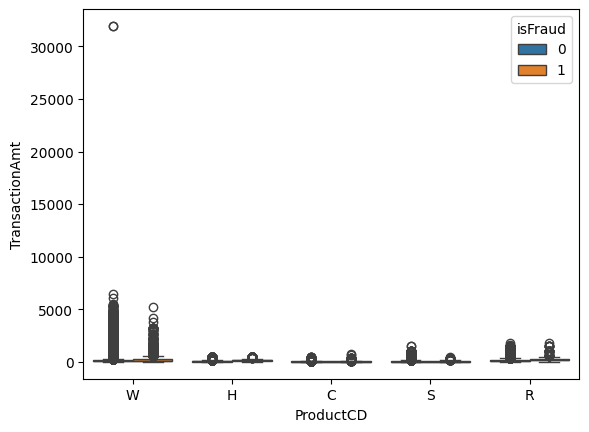

In [33]:
sns.boxplot(data=train_transaction_df, x='ProductCD', y='TransactionAmt', hue='isFraud')

<Axes: xlabel='ProductCD', ylabel='TransactionAmt_log'>

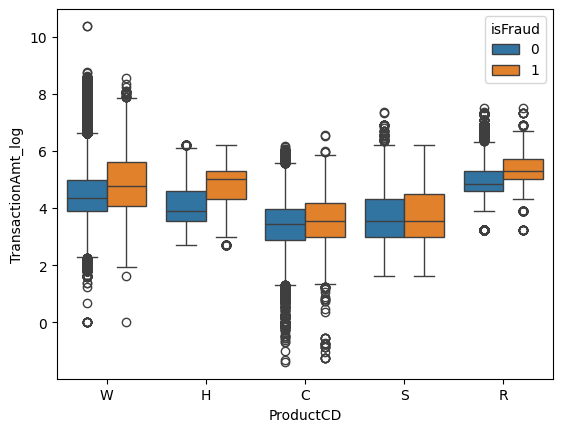

In [34]:
train_transaction_df['TransactionAmt_log'] = np.log(train_transaction_df["TransactionAmt"])
sns.boxplot(data=train_transaction_df, x='ProductCD', y='TransactionAmt_log', hue='isFraud')

### Email Domain

In [35]:
# Fill missing values in email domain columns with 'unknown' 
# to avoid NaNs and preserve the categorical nature of the data
train_transaction_df['P_emaildomain'] = train_transaction_df['P_emaildomain'].fillna('unknown')
train_transaction_df['R_emaildomain'] = train_transaction_df['R_emaildomain'].fillna('unknown')

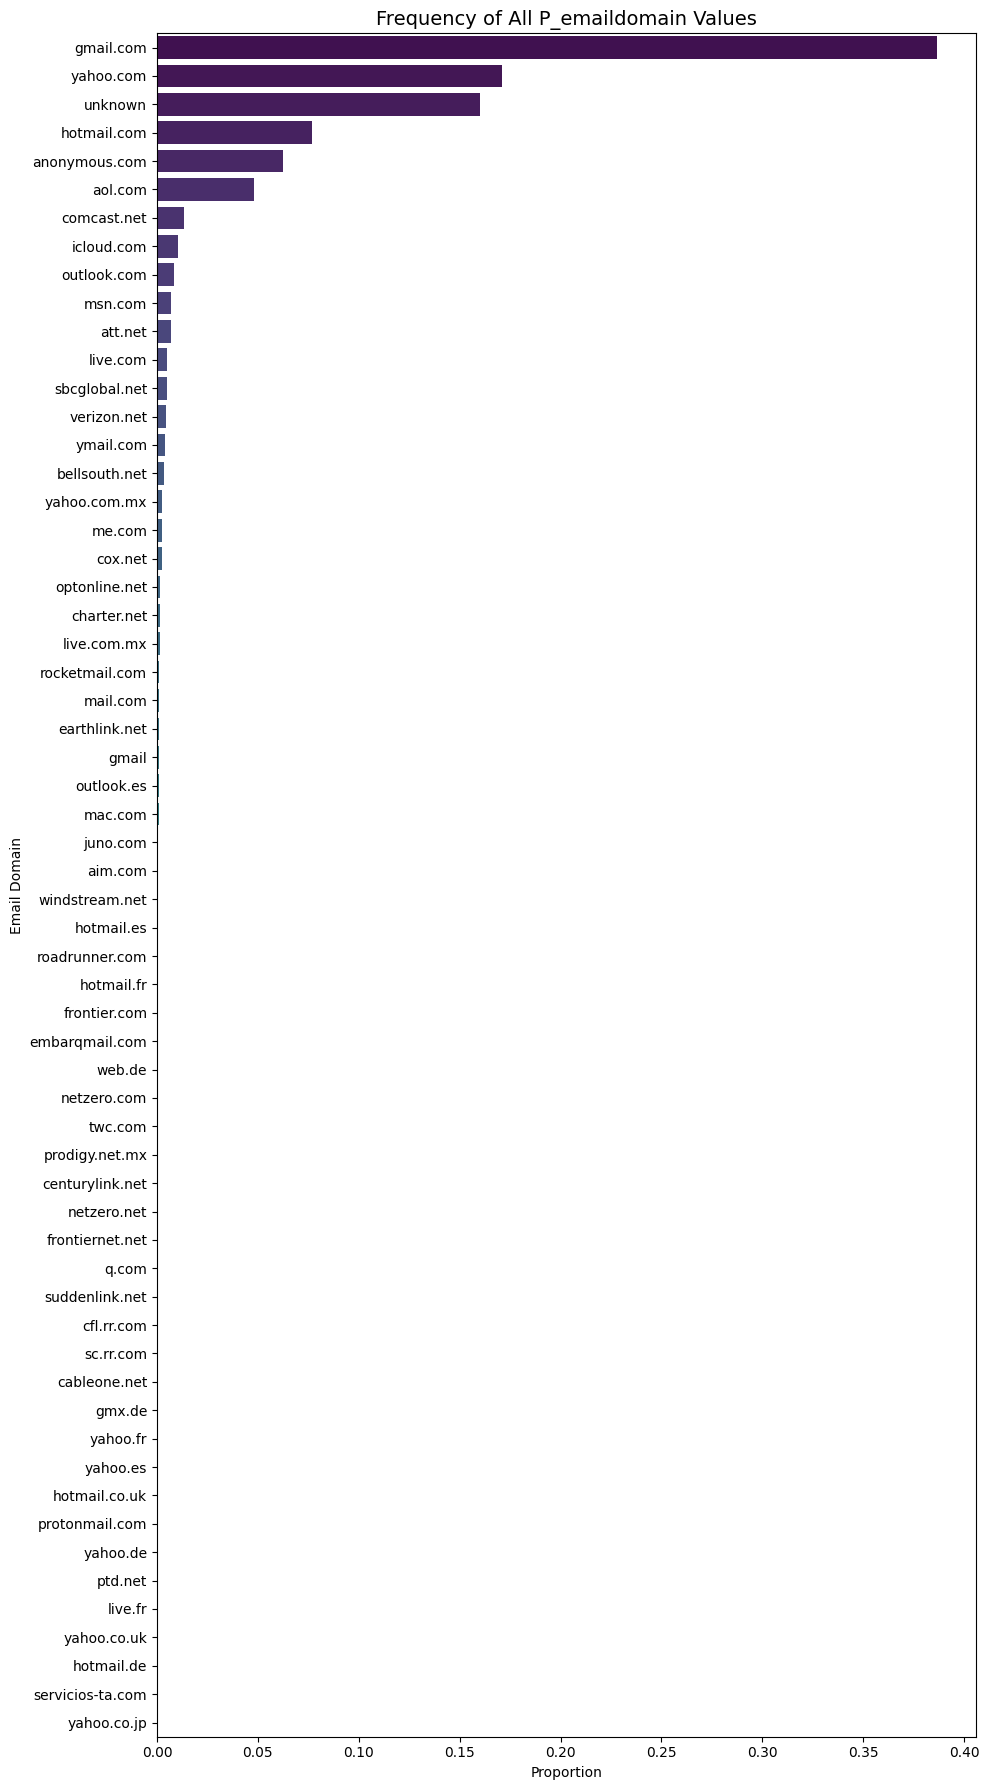

In [36]:
# Calculate proportions for all P_emaildomain values
all_domains = (
    train_transaction_df['P_emaildomain']
    .value_counts(normalize=True)
    .sort_values(ascending=False)
    .reset_index()
)
all_domains.columns = ['P_emaildomain', 'Proportion']

# Plot all domains
plt.figure(figsize=(10, max(6, len(all_domains) * 0.3)))  # Adjust height dynamically
sns.barplot(
    data=all_domains,
    x='Proportion',
    y='P_emaildomain',
    hue='P_emaildomain',       # Set hue to the same column
    palette='viridis',
    legend=False               # Hide the legend
)
plt.title("Frequency of All P_emaildomain Values", fontsize=14)
plt.xlabel("Proportion")
plt.ylabel("Email Domain")
plt.tight_layout()
plt.show()

In [37]:
# Group the dataset by 'P_emaildomain' and calculate fraud statistics.
# Then sort by fraud rate ('isFraud_rate') in descending order 
# and display the top 10 email domains with the highest fraud rates.
group_by_with_label(train_transaction_df, 'P_emaildomain', 'isFraud').sort_values('isFraud_rate', ascending=False)[:10]

,P_emaildomain,isFraud_0,isFraud_1,total,isFraud_rate
38,protonmail.com,45,31,76,0.407895
29,mail.com,453,106,559,0.189624
36,outlook.es,381,57,438,0.130137
0,aim.com,275,40,315,0.126984
35,outlook.com,4614,482,5096,0.094584
21,hotmail.es,285,20,305,0.065574
26,live.com.mx,708,41,749,0.054740
19,hotmail.com,42854,2396,45250,0.052950
16,gmail.com,218412,9943,228355,0.043542
58,yahoo.fr,138,5,143,0.034965


In [38]:
# Group the dataset by 'P_emaildomain' and compute fraud-related metrics.
# Sort the results by the count of fraudulent transactions ('isFraud_1') in descending order
# and display the top 10 email domains with the highest number of fraud cases.
group_by_with_label(train_transaction_df, 'P_emaildomain', 'isFraud').sort_values('isFraud_1', ascending=False)[:10]

,P_emaildomain,isFraud_0,isFraud_1,total,isFraud_rate
16,gmail.com,218412,9943,228355,0.043542
48,unknown,91666,2790,94456,0.029538
19,hotmail.com,42854,2396,45250,0.052950
54,yahoo.com,98637,2297,100934,0.022757
1,anonymous.com,36139,859,36998,0.023217
2,aol.com,27672,617,28289,0.021811
35,outlook.com,4614,482,5096,0.094584
9,comcast.net,7642,246,7888,0.031187
23,icloud.com,6070,197,6267,0.031434
29,mail.com,453,106,559,0.189624


In [39]:
# Group the dataset by 'P_emaildomain' and compute fraud-related metrics.
# Sort the results by the total number of transactions ('total') in descending order
# and display the top 10 email domains with the highest transaction volume.
group_by_with_label(train_transaction_df, 'P_emaildomain', 'isFraud').sort_values('total', ascending=False)[:10]

,P_emaildomain,isFraud_0,isFraud_1,total,isFraud_rate
16,gmail.com,218412,9943,228355,0.043542
54,yahoo.com,98637,2297,100934,0.022757
48,unknown,91666,2790,94456,0.029538
19,hotmail.com,42854,2396,45250,0.052950
1,anonymous.com,36139,859,36998,0.023217
2,aol.com,27672,617,28289,0.021811
9,comcast.net,7642,246,7888,0.031187
23,icloud.com,6070,197,6267,0.031434
35,outlook.com,4614,482,5096,0.094584
31,msn.com,4002,90,4092,0.021994


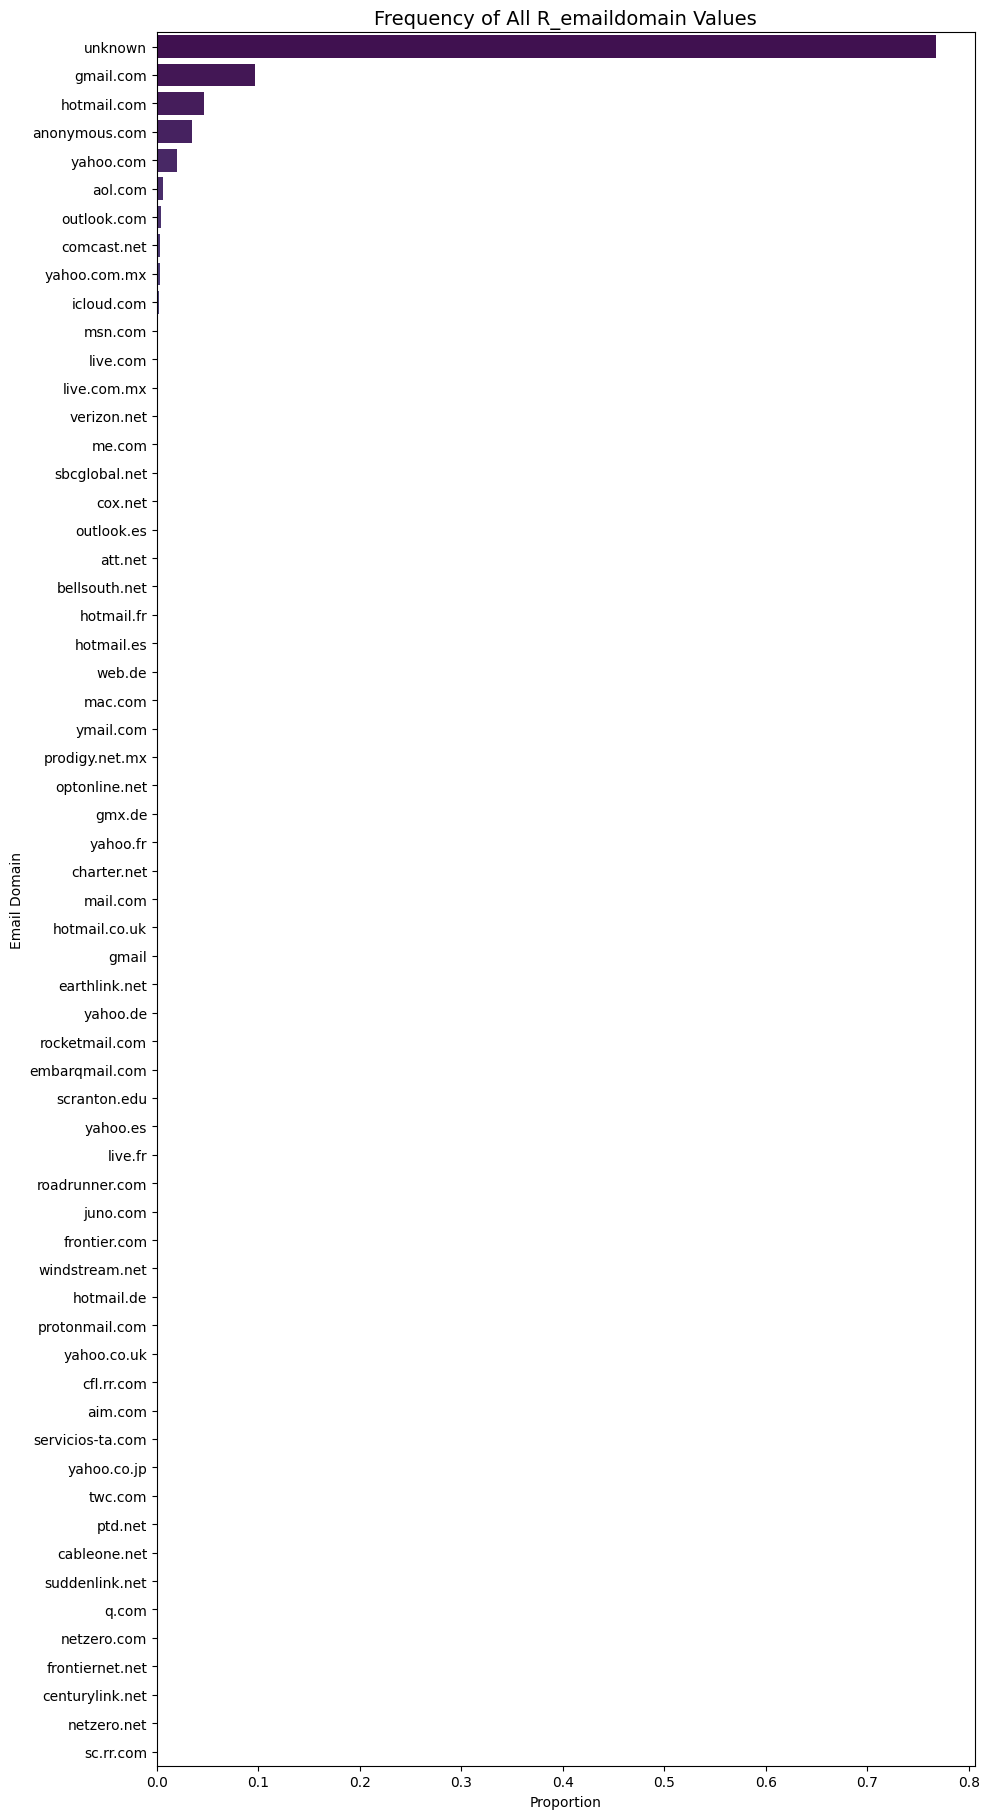

In [40]:
# Calculate proportions for all R_emaildomain values
all_domains = (
    train_transaction_df['R_emaildomain']
    .value_counts(normalize=True)
    .sort_values(ascending=False)
    .reset_index()
)
all_domains.columns = ['R_emaildomain', 'Proportion']

# Plot all domains
plt.figure(figsize=(10, max(6, len(all_domains) * 0.3)))  # Adjust height dynamically
sns.barplot(
    data=all_domains,
    x='Proportion',
    y='R_emaildomain',
    hue='R_emaildomain',       # Set hue to the same column
    palette='viridis',
    legend=False               # Hide the legend
)

plt.title("Frequency of All R_emaildomain Values", fontsize=14)
plt.xlabel("Proportion")
plt.ylabel("Email Domain")
plt.tight_layout()
plt.show()

In [41]:
# Group the dataset by 'R_emaildomain' and compute fraud-related metrics.
# Sort the results by fraud rate ('isFraud_rate') in descending order
# and display the top 10 recipient email domains with the highest fraud rate.
group_by_with_label(train_transaction_df, 'R_emaildomain', 'isFraud').sort_values('isFraud_rate', ascending=False)[:10]


,R_emaildomain,isFraud_0,isFraud_1,total,isFraud_rate
38,protonmail.com,2,39,41,0.951220
29,mail.com,76,46,122,0.377049
33,netzero.net,7,2,9,0.222222
35,outlook.com,2093,414,2507,0.165138
36,outlook.es,376,57,433,0.131640
23,icloud.com,1218,180,1398,0.128755
16,gmail.com,50336,6811,57147,0.119184
19,hotmail.com,25369,2140,27509,0.077793
11,earthlink.net,73,6,79,0.075949
21,hotmail.es,272,20,292,0.068493


In [42]:
# Group the dataset by 'R_emaildomain' and calculate fraud-related metrics.
# Sort the results by the total number of transactions ('total') in descending order
# and display the top 10 recipient email domains with the highest transaction volume.
group_by_with_label(train_transaction_df, 'R_emaildomain', 'isFraud').sort_values('total', ascending=False)[:10]

,R_emaildomain,isFraud_0,isFraud_1,total,isFraud_rate
49,unknown,443813,9436,453249,0.020819
16,gmail.com,50336,6811,57147,0.119184
19,hotmail.com,25369,2140,27509,0.077793
1,anonymous.com,19931,598,20529,0.029130
55,yahoo.com,11232,610,11842,0.051512
2,aol.com,3572,129,3701,0.034855
35,outlook.com,2093,414,2507,0.165138
9,comcast.net,1791,21,1812,0.011589
56,yahoo.com.mx,1492,16,1508,0.010610
23,icloud.com,1218,180,1398,0.128755


### C Columns

In [43]:
c_columns_df = train_transaction_df[[col for col in train_transaction_df.columns if col.startswith('C')]]

In [44]:
missing_values_percentage(c_columns_df)

C1     0.0
C2     0.0
C3     0.0
C4     0.0
C5     0.0
C6     0.0
C7     0.0
C8     0.0
C9     0.0
C10    0.0
C11    0.0
C12    0.0
C13    0.0
C14    0.0
dtype: float64

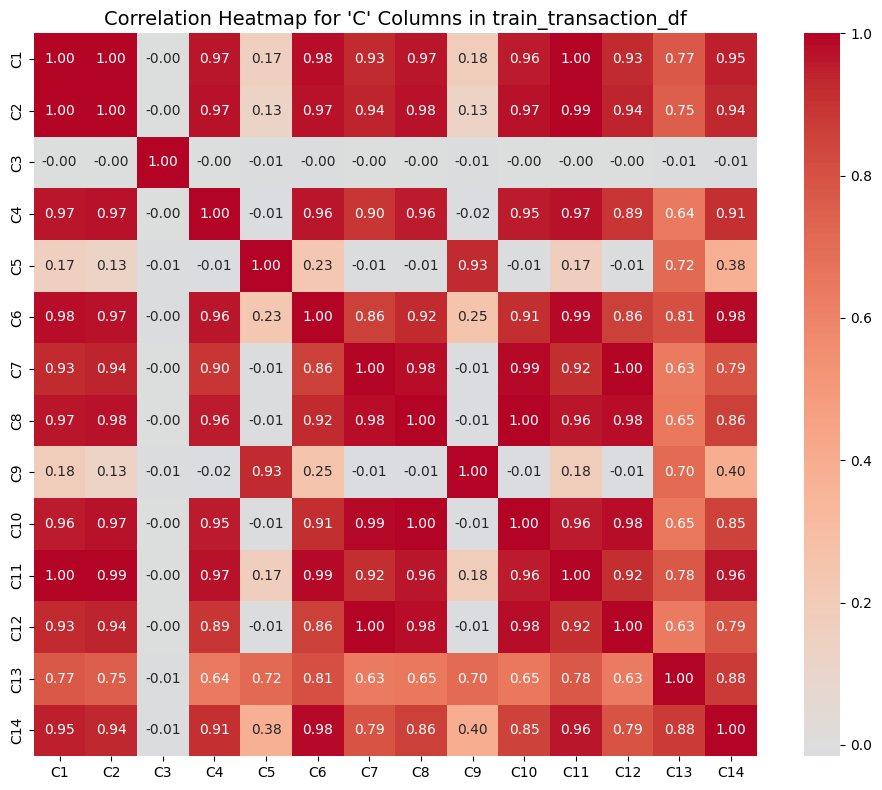

In [45]:
# Calculate correlation matrix
c_corr_matrix = c_columns_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    c_corr_matrix,
    annot=True,        # Show correlation values
    fmt=".2f",         # Format decimal
    cmap="coolwarm",   # Color map for better contrast
    center=0,          # Center color bar at 0
    square=True        # Square cells
)
plt.title("Correlation Heatmap for 'C' Columns in train_transaction_df", fontsize=14)
plt.tight_layout()
plt.show()

In [46]:
c_iv_values = {f'C{i}': calculate_iv(train_transaction_df, f'C{i}', 'isFraud') for i in range(1, 14 + 1)}

c_iv_df = pd.DataFrame(
    list(c_iv_values.items()), 
    columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)

c_iv_df

,Feature,IV
3,C4,0.871797
6,C7,0.773240
9,C10,0.734659
7,C8,0.729012
11,C12,0.699570
4,C5,0.521821
13,C14,0.446806
12,C13,0.409810
8,C9,0.396302
0,C1,0.381905


In [47]:
c_strong_predictor = c_iv_df[c_iv_df.IV >= 0.5]['Feature'].unique().tolist()
c_medium_predictor = c_iv_df[(c_iv_df.IV >= 0.1) & (c_iv_df.IV < 0.5)]['Feature'].unique().tolist()
c_weak_predictor = c_iv_df[(c_iv_df.IV >= 0.05) & (c_iv_df.IV < 0.1)]['Feature'].unique().tolist()

print(c_strong_predictor)
print(c_medium_predictor)
print(c_weak_predictor)

['C4', 'C7', 'C10', 'C8', 'C12', 'C5']
['C14', 'C13', 'C9', 'C1', 'C2', 'C11', 'C6']
[]


### V Columns

In [48]:
v_columns_df = train_transaction_df[[col for col in train_transaction_df.columns if col.startswith('V')]]

In [49]:
missing_values_percentage(v_columns_df)

V1      47.293494
V2      47.293494
V3      47.293494
V4      47.293494
V5      47.293494
          ...    
V335    86.054967
V336    86.054967
V337    86.054967
V338    86.054967
V339    86.054967
Length: 339, dtype: float64

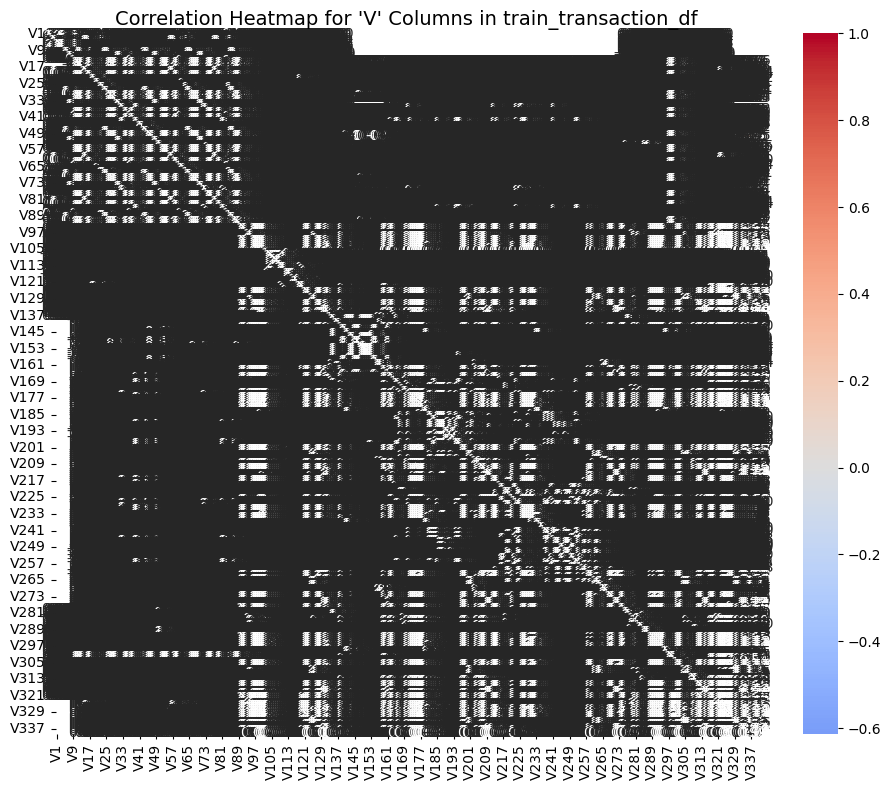

In [50]:
# Calculate correlation matrix
v_corr_matrix = v_columns_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    v_corr_matrix,
    annot=True,        # Show correlation values
    fmt=".2f",         # Format decimal
    cmap="coolwarm",   # Color map for better contrast
    center=0,          # Center color bar at 0
    square=True        # Square cells
)
plt.title("Correlation Heatmap for 'V' Columns in train_transaction_df", fontsize=14)
plt.tight_layout()
plt.show()

In [51]:
v_iv_values = {f'V{i}': calculate_iv(train_transaction_df, f'V{i}', 'isFraud') for i in range(1, 337 + 1)}

v_iv_df = pd.DataFrame(
    list(v_iv_values.items()), 
    columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)

v_iv_df

,Feature,IV
257,V258,1.618795e+00
256,V257,1.484033e+00
245,V246,1.349478e+00
148,V149,1.303430e+00
155,V156,1.298023e+00
...,...,...
27,V28,6.269672e-07
26,V27,6.174540e-07
67,V68,2.861937e-07
0,V1,3.103786e-09


In [52]:
v_strong_predictor = v_iv_df[v_iv_df.IV >= 0.5]['Feature'].unique().tolist()
v_medium_predictor = v_iv_df[(v_iv_df.IV >= 0.1) & (v_iv_df.IV < 0.5)]['Feature'].unique().tolist()
v_weak_predictor = v_iv_df[(v_iv_df.IV >= 0.05) & (v_iv_df.IV < 0.1)]['Feature'].unique().tolist()

print(v_strong_predictor)
print(v_medium_predictor)
print(v_weak_predictor)

['V258', 'V257', 'V246', 'V149', 'V156', 'V150', 'V244', 'V201', 'V243', 'V242', 'V187', 'V200', 'V148', 'V155', 'V152', 'V189', 'V151', 'V199', 'V154', 'V259', 'V158', 'V232', 'V190', 'V219', 'V218', 'V233', 'V153', 'V188', 'V229', 'V230', 'V52', 'V45', 'V245', 'V231', 'V217', 'V186', 'V51', 'V157', 'V264', 'V265', 'V44', 'V222', 'V40', 'V263', 'V178', 'V228', 'V39', 'V49', 'V179', 'V48', 'V94', 'V140', 'V79', 'V43', 'V50', 'V87', 'V42', 'V34', 'V171', 'V33', 'V91', 'V204', 'V168', 'V90', 'V93', 'V86', 'V74', 'V274', 'V203', 'V92', 'V177', 'V81', 'V29', 'V202', 'V70', 'V30', 'V15', 'V16', 'V80', 'V307', 'V69', 'V170', 'V221', 'V147', 'V275', 'V85', 'V17', 'V73', 'V18', 'V84', 'V58', 'V167', 'V273', 'V32', 'V31', 'V22', 'V21', 'V139', 'V57', 'V145', 'V165', 'V72', 'V176', 'V308', 'V60', 'V213']
['V212', 'V38', 'V71', 'V146', 'V59', 'V64', 'V211', 'V63', 'V143', 'V303', 'V310', 'V317', 'V304', 'V127', 'V249', 'V247', 'V302', 'V192', 'V144', 'V248', 'V166', 'V37', 'V10', 'V11', 'V128', '

### D Columns

In [53]:
d_columns_df = train_transaction_df[[col for col in train_transaction_df.columns if col.startswith('D')]]

In [54]:
missing_values_percentage(d_columns_df)

D1      0.214888
D2     47.549192
D3     44.514851
D4     28.604667
D5     52.467403
D6     87.606767
D7     93.409930
D8     87.312290
D9     87.312290
D10    12.873302
D11    47.293494
D12    89.041047
D13    89.509263
D14    89.469469
D15    15.090087
dtype: float64

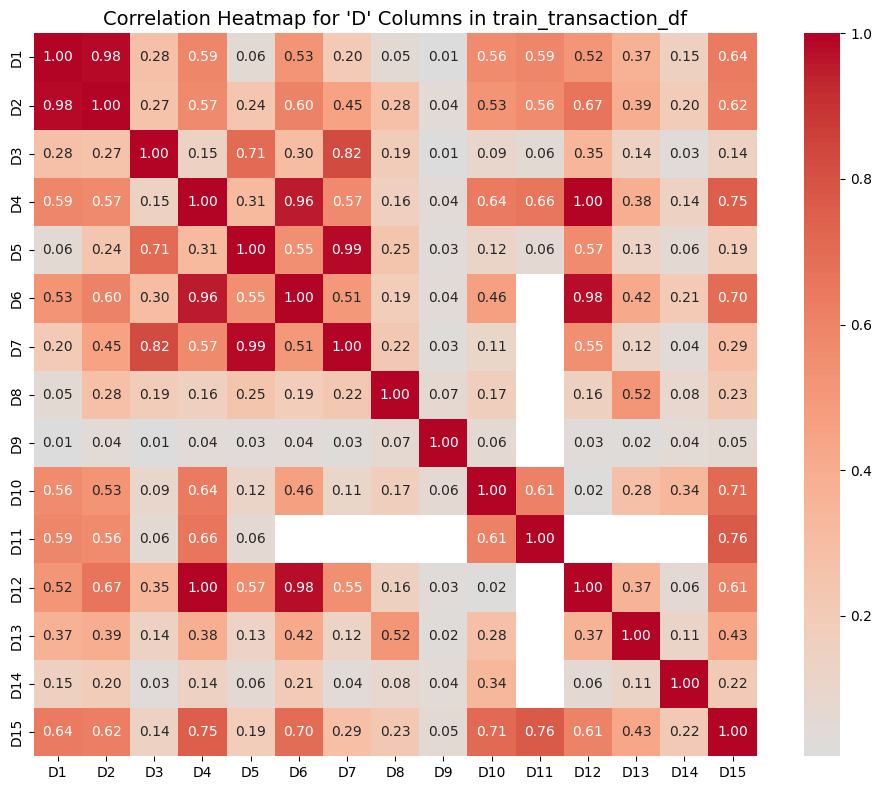

In [55]:
# Calculate correlation matrix
d_corr_matrix = d_columns_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    d_corr_matrix,
    annot=True,        # Show correlation values
    fmt=".2f",         # Format decimal
    cmap="coolwarm",   # Color map for better contrast
    center=0,          # Center color bar at 0
    square=True        # Square cells
)
plt.title("Correlation Heatmap for 'D' Columns in train_transaction_df", fontsize=14)
plt.tight_layout()
plt.show()

In [56]:
d_iv_values = {f'D{i}': calculate_iv(train_transaction_df, f'D{i}', 'isFraud') for i in range(1, 15 + 1)}

d_iv_df = pd.DataFrame(
    list(d_iv_values.items()), 
    columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)

d_iv_df

,Feature,IV
4,D5,0.906077
7,D8,0.752707
1,D2,0.659645
2,D3,0.635598
14,D15,0.457266
13,D14,0.447702
9,D10,0.410731
3,D4,0.399332
10,D11,0.374223
0,D1,0.348693


In [57]:
d_strong_predictor = d_iv_df[d_iv_df.IV >= 0.5]['Feature'].unique().tolist()
d_medium_predictor = d_iv_df[(d_iv_df.IV >= 0.1) & (d_iv_df.IV < 0.5)]['Feature'].unique().tolist()
d_weak_predictor = d_iv_df[(d_iv_df.IV >= 0.05) & (d_iv_df.IV < 0.1)]['Feature'].unique().tolist()

print(d_strong_predictor)
print(d_medium_predictor)
print(d_weak_predictor)

['D5', 'D8', 'D2', 'D3']
['D15', 'D14', 'D10', 'D4', 'D11', 'D1', 'D6', 'D12', 'D7', 'D13', 'D9']
[]


## Intersection analysis between train_identitiy_df and train_transaction_df

Total TransactionID in train_identity_df        : 144233
Total TransactionID in train_transaction_df     : 590540
All identity IDs exist in transaction file?     : True
✅ All TransactionID values from train_identity_df are present in train_transaction_df.


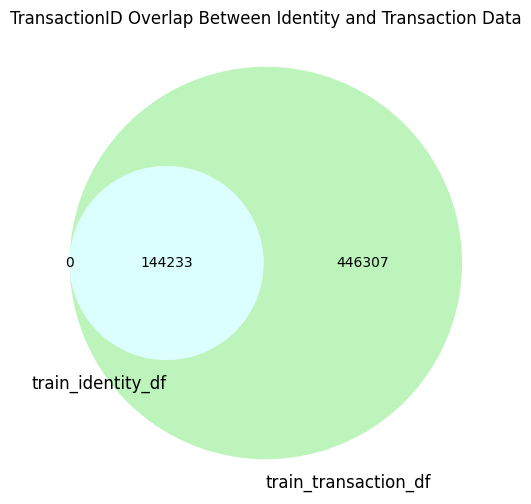

In [58]:
# Get TransactionID sets from both dataframes
ids_identity = set(train_identity_df["TransactionID"])
ids_transaction = set(train_transaction_df["TransactionID"])

# Check if all IDs in train_identity_df exist in train_transaction_df
all_exist = ids_identity.issubset(ids_transaction)

# Print the results
print(f"Total TransactionID in train_identity_df        : {len(ids_identity)}")
print(f"Total TransactionID in train_transaction_df     : {len(ids_transaction)}")
print(f"All identity IDs exist in transaction file?     : {all_exist}")

if all_exist:
    print("✅ All TransactionID values from train_identity_df are present in train_transaction_df.")
else:
    missing_ids = ids_identity - ids_transaction
    print(f"⚠️ There are {len(missing_ids)} TransactionID values in train_identity_df not found in train_transaction_df.")

# Create a Venn diagram
plt.figure(figsize=(6,6))
venn2(
    [ids_identity, ids_transaction],
    set_labels=("train_identity_df", "train_transaction_df"),
    set_colors=("skyblue", "lightgreen"),
    alpha=0.6
)
plt.title("TransactionID Overlap Between Identity and Transaction Data")
plt.show()


# Feature Engineering

## TransactionDT derived (seconds offset -> days/hours)

In [ ]:
# Create time-based features from 'TransactionDT' (which is in seconds since a reference point)
full_datasets['DT_days'] = full_datasets['TransactionDT'] / (24*60*60)

# Convert transaction time to hours of the day (0–23)
full_datasets['DT_hour'] = np.floor((full_datasets['TransactionDT'] / 3600) % 24).astype(np.int16)

# Get the day of the week (0–6) from the transaction timestamp
full_datasets['DT_weekday'] = np.floor(full_datasets['DT_days'] % 7).astype(np.int8)

# Encode the 'hour of day' as sine for cyclical representation
full_datasets['DT_hour_sin'] = np.sin(2 * np.pi * full_datasets['DT_hour'] / 24)

# Encode the 'hour of day' as cosine for cyclical representation
full_datasets['DT_hour_cos'] = np.cos(2 * np.pi * full_datasets['DT_hour'] / 24)

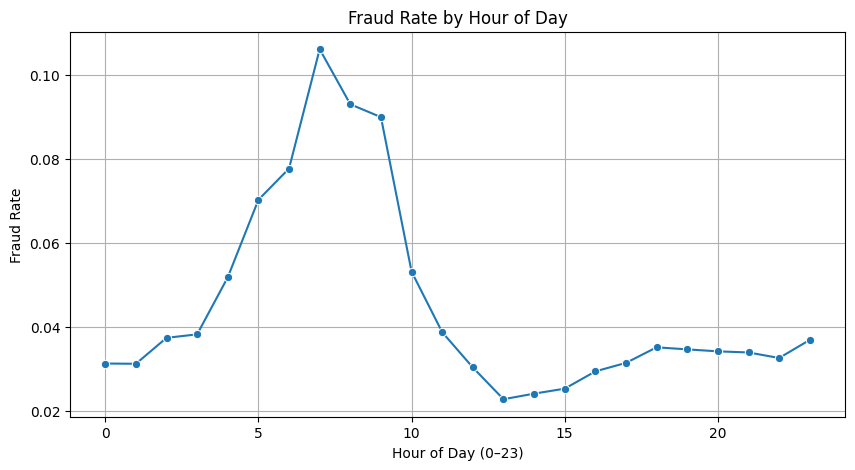

In [60]:
# Fraud rate by hour of day
plt.figure(figsize=(10,5))
fraud_by_hour = full_datasets.groupby('DT_hour')['isFraud'].mean()
sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour.values, marker='o')
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Fraud Rate")
plt.grid(True)
plt.show()

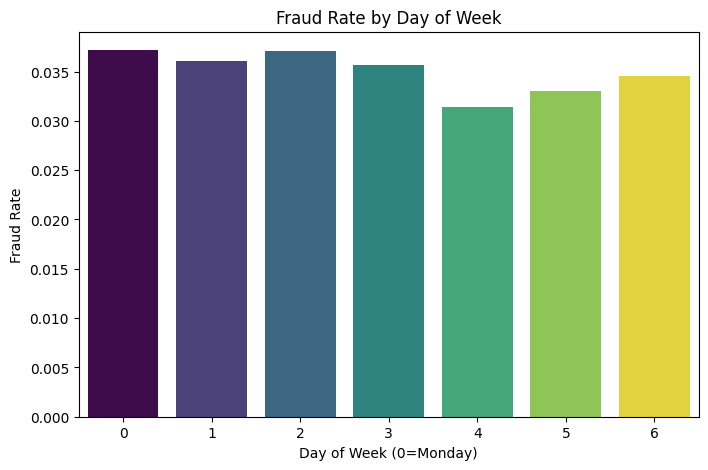

In [61]:
# Fraud rate by day of week
plt.figure(figsize=(8,5))
fraud_by_weekday = full_datasets.groupby('DT_weekday')['isFraud'].mean()
sns.barplot(
    x=fraud_by_weekday.index, 
    y=fraud_by_weekday.values, 
    hue=fraud_by_weekday.index,  
    palette="viridis",
    legend=False                
)

plt.title("Fraud Rate by Day of Week")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Fraud Rate")
plt.show()

## TransactionAmt transforms

In [ ]:
# Apply log transformation to transaction amount to reduce skewness and handle large outliers
full_datasets['TransactionAmt_log'] = np.log1p(full_datasets['TransactionAmt'])

# Extract the decimal (fractional) part of the transaction amount, rounded to 6 decimal places
full_datasets['TransactionAmt_decimal'] = (
    full_datasets['TransactionAmt'] - np.floor(full_datasets['TransactionAmt'])
).round(6)

# Round the transaction amount to the nearest integer
full_datasets['TransactionAmt_round'] = full_datasets['TransactionAmt'].round(0)

## Device info cleaning

In [ ]:
def clean_device(x):
    if pd.isna(x):
        return "unknown"  # Replace missing values with 'unknown'
    
    s = str(x).lower()    # Convert to lowercase for consistent matching
    
    # Identify and categorize device types based on keywords
    if "sm-" in s or "samsung" in s: return "samsung"
    if "iphone" in s or "ios" in s: return "iphone"
    if "windows" in s: return "windows"
    if "mac os" in s or "macos" in s or "mac " in s: return "mac"
    if "linux" in s: return "linux"
    
    # If no match, take the part before a slash (to simplify versioned device names)
    return s.split('/')[0]

# Apply cleaning to the 'DeviceInfo' column and store in a new feature
full_datasets['DeviceInfo_clean'] = full_datasets['DeviceInfo'].map(clean_device)

## Email domain groups: top domains + others

In [ ]:
# Fill missing values in 'P_emaildomain' with the string "unknown"
full_datasets['P_emaildomain'] = full_datasets['P_emaildomain'].fillna("unknown")

# From the training set (isTrain == 1), find the 30 most frequent email domains
top_domains = (
    full_datasets.loc[full_datasets['isTrain'] == 1, 'P_emaildomain']
    .value_counts()
    .nlargest(30)
    .index
    .tolist()
)

# Create a new column 'P_email_group' where:
full_datasets['P_email_group'] = full_datasets['P_emaildomain'].where(
    full_datasets['P_emaildomain'].isin(top_domains),
    other='other'
)

## UID combos

In [ ]:
# Combine 'card1' and 'addr1' into a unique identifier string
full_datasets['uid_card1_addr1'] = (
    full_datasets['card1'].astype(str) + '_' + full_datasets['addr1'].astype(str)
)

# Extend the above identifier by adding the processed email domain group
full_datasets['uid_card1_addr1_email'] = (
    full_datasets['uid_card1_addr1'] + '_' + full_datasets['P_email_group'].astype(str)
)

# Create another unique identifier by combining 'card1' and 'card2'
full_datasets['uid_card'] = (
    full_datasets['card1'].astype(str) + '_' + full_datasets['card2'].astype(str)
)

# Create a more detailed unique identifier combining 'card1', 'card2', and 'card3'
full_datasets['uid_card_card3'] = (
    full_datasets['card1'].astype(str) + '_' +
    full_datasets['card2'].astype(str) + '_' +
    full_datasets['card3'].astype(str)
)

## Missing flags for important cols (identity features large set)

In [70]:
# List of important categorical/numerical columns to check for missing values
important_cols = [
    'DeviceInfo', 'DeviceType', 'P_emaildomain', 'R_emaildomain',
    'card1', 'card2', 'card3', 'card5'
]

# Loop through each column in the list
for c in important_cols:
    # Only process the column if it exists in the dataset
    if c in full_datasets.columns:
        # Create a new binary feature indicating whether the value is missing (1) or not missing (0)
        # .isna() → returns True for missing values
        # .astype(np.int8) → converts boolean to integer (True → 1, False → 0) for memory efficiency
        full_datasets[c + '_na'] = full_datasets[c].isna().astype(np.int8)

## Count of missing per row

In [69]:
full_datasets['missing_count'] = full_datasets.isnull().sum(axis=1).astype(np.int16)

## Frequency encodings (from train only)

In [71]:
# Create a boolean mask to filter only training data
train_mask = full_datasets['isTrain'] == 1

# List of categorical columns for which frequency encoding will be created
freq_cols = [
    'ProductCD', 'card1', 'card2', 'card3', 'card5',
    'uid_card1_addr1', 'uid_card',
    'P_email_group', 'DeviceInfo_clean', 'DeviceType'
]

# Loop through each column in freq_cols
for col in freq_cols:
    # Skip the column if it doesn't exist in the dataset
    if col not in full_datasets.columns:
        continue
    
    # Count the frequency of each unique value in the training data
    # dropna=False ensures NaN values are also counted
    vc = full_datasets.loc[train_mask, col].value_counts(dropna=False)
    
    # Convert the frequency counts into a dictionary {value: frequency}
    mapping = vc.to_dict()
    
    # Map each value in the full dataset to its frequency
    # - If the value doesn't exist in mapping → replace with 0
    # - Store the result in a new column with "_freq" suffix
    # - Convert the data type to int32 for efficiency
    full_datasets[col + '_freq'] = (
        full_datasets[col]
        .map(mapping)
        .fillna(0)
        .astype(np.int32)
    )

## Aggregations based on train only -> merge to full

In [73]:
# List of target numerical features to aggregate
agg_targets = ['TransactionAmt', 'TransactionAmt_log', 'TransactionDT']

# List of unique identifier feature combinations for grouping
uid_keys = [
    'uid_card1_addr1', 
    'uid_card1_addr1_email', 
    'uid_card', 
    'uid_card_card3'
]

# Aggregation functions to apply for each group
agg_funcs = ['mean', 'std', 'min', 'max', 'median', 'count']

# Loop through each unique identifier key
for uid in uid_keys:
    # Skip if the UID column does not exist in the dataset
    if uid not in full_datasets.columns:
        continue
    
    # Group the training data by the UID
    train_grp = full_datasets.loc[train_mask].groupby(uid)
    
    # Compute aggregation statistics for the selected numerical features
    agg_df = train_grp[agg_targets].agg(agg_funcs)
    
    # Flatten multi-level column names into a single string
    # Example: ('TransactionAmt', 'mean') → 'uid_card1_addr1_TransactionAmt_mean'
    agg_df.columns = [f"{uid}_{col[0]}_{col[1]}" for col in agg_df.columns]
    
    # Reset index so UID becomes a normal column
    agg_df = agg_df.reset_index()
    
    # Merge the aggregated features back into the main dataset
    # Use 'left' join so all original rows are kept
    full_datasets = full_datasets.merge(agg_df, on=uid, how='left')

# Identify all aggregated columns by searching for aggregation suffixes
agg_cols = [
    c for c in full_datasets.columns 
    if any(s in c for s in ['_mean', '_std', '_min', '_max', '_median', '_count'])
]

# Fill missing aggregated values (for UIDs present in test but not in train) with -1
full_datasets[agg_cols] = full_datasets[agg_cols].fillna(-1)

## Ratios: TransactionAmt / uid_mean

In [77]:
for uid in uid_keys:
    mean_col = f"{uid}_TransactionAmt_mean"
    if mean_col in full_datasets.columns:
        # Create ratio feature, avoiding division by zero
        ratio = full_datasets['TransactionAmt'] / full_datasets[mean_col].replace({0: np.nan})
        
        # Replace infinities and NaN
        ratio = ratio.replace([np.inf, -np.inf], np.nan)
        ratio = ratio.fillna(-1)
        
        # Assign back to DataFrame
        full_datasets[f"amt_div_{uid}_mean"] = ratio

## Interaction & statistical features

In [ ]:
# Calculate number of unique email domains per card1 in the training set and map it to the full dataset
if 'card1' in full_datasets.columns:
    # Group by 'card1' in training data, count unique 'P_email_group' values, convert to dictionary
    card1_email_counts = full_datasets.loc[train_mask].groupby('card1')['P_email_group'].nunique().to_dict()
    
    # Map the counts back to 'card1' for all rows in the full dataset
    # Fill missing values with 0 for unseen card1 values in test set
    # Convert to int16 for memory efficiency
    full['card1_email_unique'] = full['card1'].map(card1_email_counts).fillna(0).astype(np.int16)

# Calculate total transaction counts per card1 in the training set and map it to the full dataset
if 'card1' in full.columns:
    # Group by 'card1' in training data, count total transactions, convert to dictionary
    card1_txn_counts = full.loc[train_mask].groupby('card1').size().to_dict()
    
    # Map the counts back to 'card1' for all rows in the full dataset
    # Fill missing values with 0 for unseen card1 values in test set
    # Convert to int32 for memory efficiency (transaction counts can be larger than unique emails)
    full['card1_txn_count'] = full['card1'].map(card1_txn_counts).fillna(0).astype(np.int32)
